https://stackoverflow.com/questions/11850105/hue-to-wavelength-mapping

In [1]:
import sys
sys.path.append("/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages")

In [2]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from scipy.io import wavfile
import time

In [3]:
video_path = "flyover3.mp4"
capture = cv2.VideoCapture(video_path)
print(capture.isOpened())

#if(capture.isOpened()):
#    handle, frame = capture.read()
#    if(handle):
#        cv2.imshow("Frame", frame)
        
#        if(cv2.waitKey(25) & 0xFF == ord('q')):
#            cv2.destroyAllWindows()

#else:
#    print("Error reading the video file")'''

True


In [4]:
N_FRAMES = capture.get(cv2.CAP_PROP_FRAME_COUNT)
FPS = capture.get(cv2.CAP_PROP_FPS)
VIDEO_LENGTH = N_FRAMES/ FPS

print("No of Frames: ", N_FRAMES)
print("FPS: ",FPS)
print("Length: ", VIDEO_LENGTH)

No of Frames:  1799.0
FPS:  29.97002997002997
Length:  60.026633333333336


In [5]:
H = []
S = []
V = []

start = time.time()

while not capture.isOpened():
    capture = cv2.VideoCapture(video_path)

pointerFrame = capture.get(cv2.CAP_PROP_POS_FRAMES)
attempts = 0
current = pointerFrame

while True:
    flag, frame = capture.read()
    
    if flag:
        # Frame is ready and already captured
        hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
        
        H.append(hsv[:, :, 0])
        S.append(hsv[:, :, 1])
        V.append(hsv[:, :, 2])
        # print(pointerFrame)
        current = pointerFrame
        pointerFrame = capture.get(cv2.CAP_PROP_POS_FRAMES)
        
    else:
        # Frame is not ready
        
        if(current == pointerFrame and attempts > 10):
            attempts = 0
            break
        else:           
            #print("Not Ready")
            attempts += 1
            capture.set(cv2.CAP_PROP_POS_FRAMES, pointerFrame - 1)      
        
    if N_FRAMES == cv2.CAP_PROP_POS_FRAMES:
        break
        
if (int(N_FRAMES) < len(H)):
    H = H[0: int(N_FRAMES)]
    S = S[0: int(N_FRAMES)]
    V = V[0: int(N_FRAMES)]
    
end = time.time()

H = np.array(H)
S = np.array(S)
V = np.array(V)

print("Execution Time: ", end - start)
print(len(H), len(S), len(V))

Execution Time:  5.731460809707642
1799 1799 1799


In [6]:
wavelengths = []

start = time.time()

for i in range(int(N_FRAMES)):
    L = 650 - 250 / 270 * H[i]
    wavelengths.append(sum(L)/FPS)

wavelengths = np.array(wavelengths)   

end = time.time()

print("Execution time: ", end - start)
print(wavelengths.shape)

Execution time:  10.93595290184021
(1799, 1280)


In [7]:
saturations = []

for i in range (int(N_FRAMES)):
    saturations.append(sum(S[i])/FPS)

saturations = np.array(saturations)
print(saturations.shape)

(1799, 1280)


In [8]:
values = [] #brightness

for i in range (int(N_FRAMES)):
    values.append(sum(V[i])/FPS)

values = np.array(values)
print(values.shape)

(1799, 1280)


In [9]:
speed_of_light = 3* pow(10,8)

frequencies = np.array([speed_of_light/ wavelengths[i] * pow(10, -9) for i in range(wavelengths.shape[0])])

print(type(frequencies), frequencies.shape)

<class 'numpy.ndarray'> (1799, 1280)


In [10]:
minFreq = np.min(frequencies)
maxFreq = np.max(frequencies)

frequencies = np.array([(((frequencies[i] - minFreq)*(4186.0 - 27.5)) / (maxFreq - minFreq + 1)) + 27.5 for i in range(len(frequencies))])

print(minFreq, maxFreq)

1.9211557673096134e-05 2.2660114744712917e-05


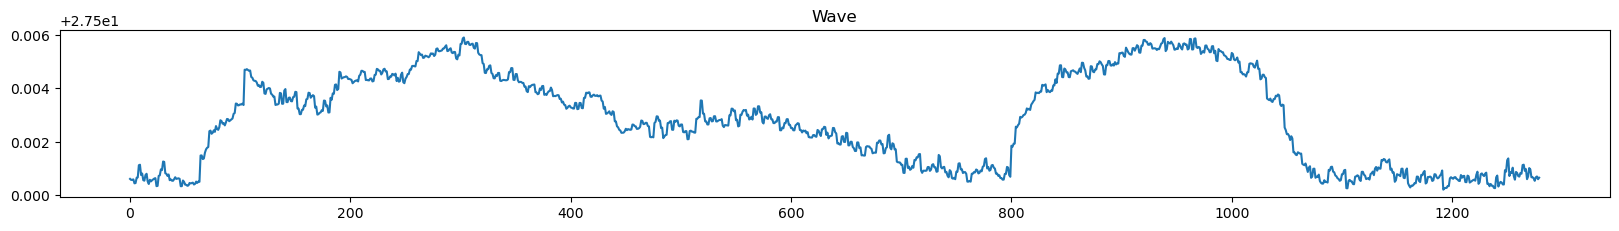

In [11]:
plt.figure(figsize=(20,10))

plt.subplot(4,1,1)
plt.plot(frequencies[0])
plt.subplot(4,1,1).set_title("Wave")

plt.show()

In [12]:
SAMPLE_RATE = FPS * N_FRAMES

In [13]:
def get_wave(frequency, duration = 0.5, amplitude = 4096):
    t = np.linspace(0, duration, int(SAMPLE_RATE*duration))
    wave = amplitude * np.sin(2* np.pi* frequency* t) # A sin(2*pi*f*t)
    return wave

In [14]:
final = []

n = 0

while n < (int(N_FRAMES)):
    final.append(sum(frequencies[n: n+int(FPS)])/FPS)
    n += int(FPS)

final = np.array(final)
print(len(final))
print(final.shape)

63
(63, 1280)


In [15]:
overtones = []

n = 0

while n < (int(N_FRAMES)):
    overtones.append(sum(saturations[n: n+int(FPS)])/FPS)
    n += int(FPS)
    
overtones = np.array(overtones)
print(overtones.shape)

(63, 1280)


In [16]:
amplitudes = []

n = 0

while n < (int(N_FRAMES)):
    amplitudes.append(sum(values[n: n+int(FPS)])/FPS)
    n += int(FPS)
    
amplitudes = np.array(amplitudes)
print(amplitudes.shape)

(63, 1280)


In [19]:
# Making waves based frequencies and amplitudes

wave1 = []
wave2 = []

time = 1

for i in range(final.shape[0]):
    if(i%2 != 0):
        wave2.append(get_wave(np.float64(0.0), time*1.5, 0))
    else:
        wave2.append(get_wave(sum(overtones[i])/FPS, time/2, sum(amplitudes[i])))
        
    wave1.append(get_wave(sum(final[i])/FPS, time, sum(amplitudes[i])))
    
wave1 = np.concatenate(wave1)
wave2 = np.concatenate(wave2)

print(len(wave1), len(wave2))

3396708 3369750


In [20]:
waves = [wave1, wave2]
maxCols = max(wave.shape[0] for wave in waves)

wave1 = np.hstack((wave1, np.zeros(maxCols - wave1.shape[0])))
wave2 = np.hstack((wave2, np.zeros(maxCols - wave2.shape[0])))
  
wave = wave1 + wave2
print(wave.shape)

(3396708,)


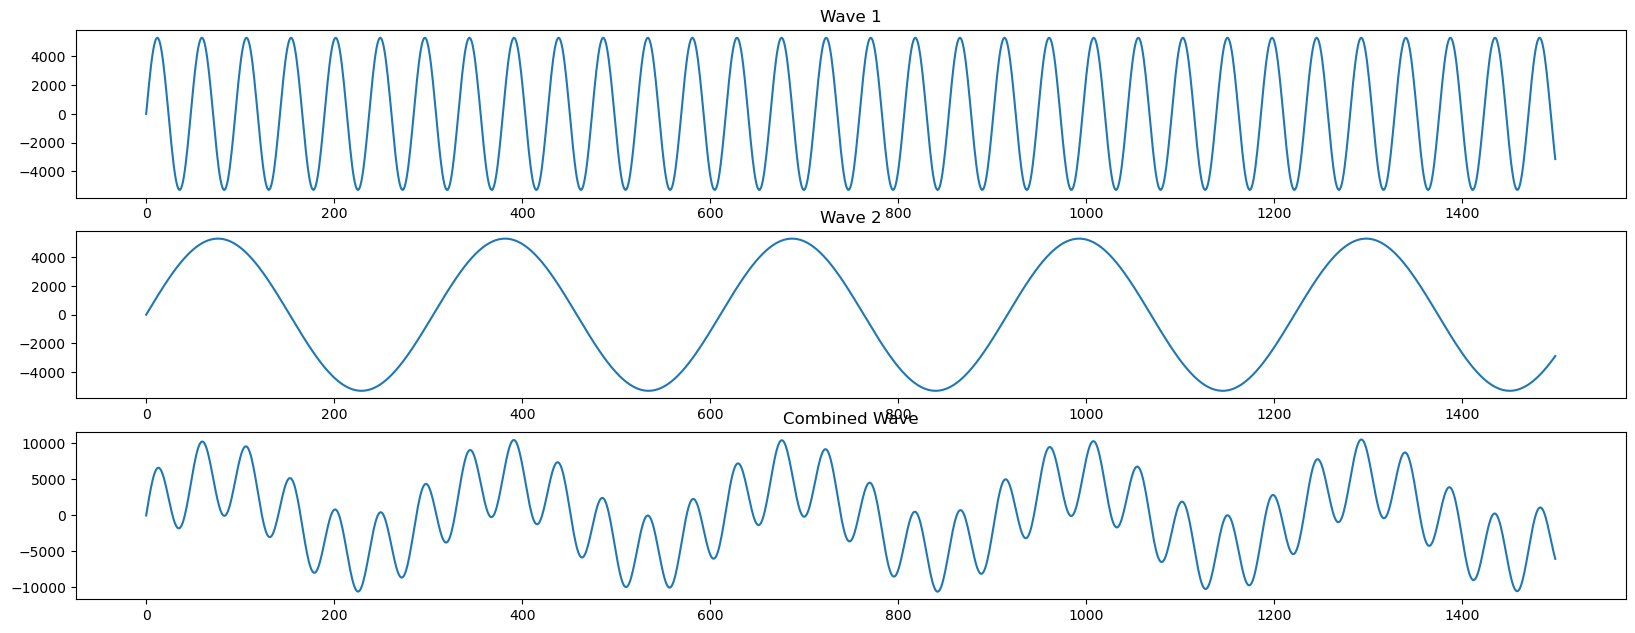

In [21]:
plt.figure(figsize=(20,10))

plt.subplot(4,1,1)
plt.plot(wave1[0: 1500])
plt.subplot(4,1,1).set_title("Wave 1")

plt.subplot(4,1,2)
plt.plot(wave2[0: 1500])
plt.subplot(4,1,2).set_title("Wave 2")

plt.subplot(4,1,3)
plt.plot(wave[0: 1500])
plt.subplot(4,1,3).set_title("Combined Wave")

plt.show()

In [22]:
minFreq = np.min(wave)
maxFreq = np.max(wave)

for i in range(len(wave)):
    wave[i] = (((wave[i] - minFreq)*(4186.0 - 27.5))/(maxFreq - minFreq)) + 27.5

In [23]:
wavfile.write('hsv.wav', int(SAMPLE_RATE), wave.astype(np.int16))